In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

#Using Latex
plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Serif"]
})

rng = np.random.default_rng(0) #Setting the seed for reproductibility for the moment 

### Hamiltonian
$H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$


To this it is going to be added a Phase decoherence term of amplitude $\gamma_{n}$ to each of the spins

In [2]:
def single_particle_qubit_operators(num_spins):
    operators = {
        'X': [],
        'Y': [],
        'Z': []
    }
    for n in range(num_spins):
        Id = [qeye(2)]*num_spins
        for (name, op) in zip(['X', 'Y', 'Z'], [sigmax(), sigmay(), sigmaz()]):
            Id[n] = op
            operators[name].append(tensor(Id))
    return operators

def lindblad_operators(num_spins, h, J, gamma):
    ops = single_particle_qubit_operators(num_spins)
    # construct the Hamiltonian
    H = 0

    # energy splitting terms
    for n in range(num_spins):
        H += - 0.5 * h[n] * ops['Z'][n]

    # interaction terms
    for n in range(num_spins-1):
        for direction in ['X', 'Y', 'Z']:
            H += - 0.5 * J[direction][n] * ops[direction][n] * ops[direction][n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(num_spins):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * ops['Z'][n])
    return H, c_op_list, ops #Hamiltonian, collapse operators, single_particle_operators

In [3]:
num_spins = 4           # number of spins
two_pi = np.full(num_spins, 2*np.pi)

interaction_coupling_constant = 0.1
h = two_pi
J = {
    'X': two_pi*interaction_coupling_constant,
    'Y': two_pi*interaction_coupling_constant,
    'Z': two_pi*interaction_coupling_constant
}

# dephasing rate
gamma = 0.01 * np.ones(num_spins)

# intial state, first spin in state |1>, the rest in state |0>
psi_list = [basis(2,0)]*num_spins #Init everything at |0>
psi_list[0] = basis(2,1) #Set first spin at |1>


initial_state = tensor(psi_list)
integration_times = np.linspace(0, 100, 300)

H, collapse_operators, sp_operators = lindblad_operators(num_spins, h, J, gamma)
options = Options()
options.store_states = True
result = mesolve(H, initial_state, integration_times, collapse_operators, sp_operators['Z'], options=options)


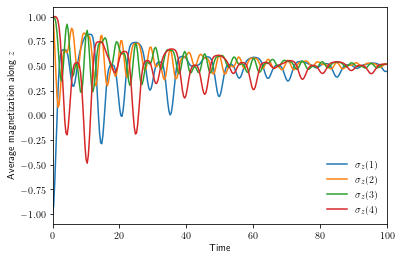

In [4]:
plt.plot(result.times, np.array(result.expect).T, label=[f"$\sigma_z({i + 1})$" for i in range(num_spins)])
plt.margins(x=0)
plt.ylabel('Average magnetization along $z$')
plt.xlabel('Time')
plt.legend(frameon=False)

### ML on resulted quantum states

In [5]:
#Kooplearn imports
import sys
sys.path.append("../../")
from kooplearn.kernels import Kernel
from kooplearn.estimators import ReducedRank, PrincipalComponent

class ComplexLinear(Kernel):
    def __call__(self, X, Y=None, backend = 'numpy'):
        if backend =='keops':
            raise NotImplementedError('Complex Kernel not yet implemented for Keops backend')
        else:
            if Y is None:
                return np.dot(X.conj(), X.T)
            else:
                return np.dot(X, Y.conj().T)

In [6]:
density_matrix_trajectory = np.array([rho.data.todense() for rho in result.states])
flattened_trajectory = np.reshape(density_matrix_trajectory, (density_matrix_trajectory.shape[0], -1))

In [7]:
init_states = flattened_trajectory[:-1]
evolved_states = flattened_trajectory[1:]

kernel = ComplexLinear()
estimator = ReducedRank(kernel=kernel, rank=7, tikhonov_reg=1e-9, override_array_checks=True)
estimator = PrincipalComponent(kernel=kernel, rank=7,  override_array_checks=True)

In [8]:
estimator.fit(init_states, evolved_states)

PrincipalComponent(kernel=<__main__.ComplexLinear object at 0x7f8949429760>,
                   override_array_checks=True, rank=7)

In [9]:
vals, lf, rf = estimator.eig(left=True, right=True)

In [11]:
timestep = result.times[1] - result.times[0]

In [12]:
#Timescales in units of timestep for given eigenvalues
def eigenvalues_timescale(eigenvalues, timestep):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around((-np.log(np.abs(ev))**-1)*timestep, decimals = 2)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            period = None
            data.append((decay_length, period))
        else:
            #Imaginary eigenvalue
            period = np.around(2*np.pi*(np.angle(ev)**-1)*timestep, decimals=2)
            data.append((decay_length, period))
    #Data format: (decay_length, period)
    return data

#Print timescales in units of timestep for given eigenvalues
def print_timescale(eigenvalues, timestep, units=''):
    data = eigenvalues_timescale(eigenvalues, timestep) 
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        elif x[1] <= 0:
            pass
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Period: {x[1]} {units}")

In [13]:
print_timescale(vals, timestep)

Decay:1386.25 
Decay: 32.07     Period: 17.22 
Decay: 32.15     Period: 7.07 
Decay: 29.94     Period: 4.95 


In [14]:
ts = eigenvalues_timescale(vals, timestep)

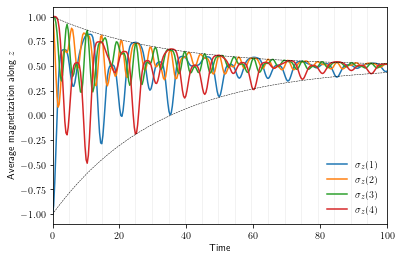

In [15]:
plt.plot(result.times, np.array(result.expect).T, label=[f"$\sigma_z({i + 1})$" for i in range(num_spins)])
plt.plot(result.times, 0.5*np.exp(-result.times/ts[1][0]) + 0.5, 'k--', lw=0.5)
plt.plot(result.times, -1.5*np.exp(-result.times/ts[1][0]) + 0.5, 'k--', lw=0.5)
for i in range(20):
    plt.axvline(i*np.abs(ts[5][1]), color='k', lw=0.5, alpha=0.1)
plt.margins(x=0)
plt.ylabel('Average magnetization along $z$')
plt.xlabel('Time')
plt.legend(frameon=False)

### Questions:
1. Compute eigenfunctions of the Koopman operator and compare it to the eigenfunctions of the Liouvillian
2. Mode decomposition + dynamics discovery

In [16]:
modes = estimator.modes()
levecs = lf(np.eye(256))
revecs = rf(np.eye(256))
left_right_norms, _, _ = estimator._eig(_for_koopman_modes=True)

In [17]:
np.abs(estimator.V_.imag).max()

8.823733434090336e-15

In [18]:
Id = levecs.conj().T@revecs@left_right_norms
np.allclose(np.eye(7), Id)

True

In [19]:
nl = modes.T@revecs

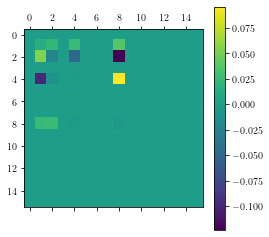

In [24]:
plt.matshow(np.imag(np.reshape(modes[:,6], (16,16))))
plt.colorbar()
